## 初始化模型参数

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l
is_cuda_available = torch.cuda.is_available()
if is_cuda_available:
    print("CUDA is available! PyTorch is using the GPU.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU index: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = d2l.try_gpu(0)
else:
    print("CUDA is not available. PyTorch is using the CPU.")

CUDA is available! PyTorch is using the GPU.
Number of GPUs available: 1
Current GPU index: 0
Current GPU name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [76]:
from d2l.torch import get_dataloader_workers, Animator
from torch.utils import data
import torchvision
from torchvision import transforms

batch_size = 256


def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../../data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='../../data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers()))


train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [77]:
num_inputs = 784
num_outputs = 10

1.  **线性模型**：对于每个输入样本 $\mathbf{x}$，模型会计算出它属于每个类别 $k$ 的一个“分数”（或称为 logit），记为 $o_k$。这个计算过程是线性的：
    $$
    \mathbf{o} = \mathbf{X}\mathbf{W} + \mathbf{b}
    $$
    其中：
    *   $\mathbf{X}$ 是输入特征矩阵，每一行是一个样本。
    *   $\mathbf{W}$ 是权重矩阵。
    *   $\mathbf{b}$ 是偏置向量。
    *   $\mathbf{o}$ 是输出的 logits 矩阵，每一行代表一个样本对应所有类别的分数。

In [78]:
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), device=device, requires_grad=True)
b = torch.zeros(num_outputs, device=device, requires_grad=True)

## 定义softmax
操作2.  **Softmax 函数**：得到这些分数后，直接比较大小是不够的，我们希望得到一个概率分布。Softmax 函数可以将这些任意实数的分数转换成一个概率分布，其中每个类别的概率值都在 (0, 1) 之间，且所有类别的概率之和为 1。对于单个样本的输出向量 $\mathbf{o} = (o_1, o_2, ..., o_K)$，其 Softmax 变换后的概率向量 $\hat{\mathbf{y}}$ 中第 $i$ 个元素为：
    $$
    \hat{y}_i = \text{softmax}(\mathbf{o})_i = \frac{\exp(o_i)}{\sum_{j=1}^{K} \exp(o_j)}
    $$
    其中 $K$ 是类别的总数。

In [79]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

## 定义模型

In [80]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

## 定义损失函数

3.  **损失函数 (Cross-Entropy Loss)**：为了衡量模型预测的好坏，我们使用交叉熵损失函数。对于单个样本，其真实标签通常用 one-hot 向量 $\mathbf{y}$ 表示（例如，如果真实类别是第 $c$ 类，则 $y_c=1$，其余 $y_j=0$）。损失函数定义为：
    $$
    L(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^{K} y_j \log(\hat{y}_j)
    $$
    因为 $\mathbf{y}$ 是 one-hot 向量，这个求和式可以简化为：
    $$
    L = -\log(\hat{y}_c)
    $$
    其中 $c$ 是该样本的真实类别索引。我们的目标就是最小化这个损失。


In [81]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

## 分类精度

In [82]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        """
        如果 `y_hat` 的前两行是：`tensor([[0.1, 0.2, 0.7],  # 样本0，预测为类别2``[0.8, 0.1, 0.1]]) # 样本1，预测为类别0`经过 `y_hat.argmax(axis=1)` 后，`y_hat` 会变成：`tensor([2, 0])`
        """
        y_hat = y_hat.argmax(axis=1)
    """
    如果 `y_hat` (预测) 是 `tensor([2, 0])`，而 `y` (真实) 是 `tensor([2, 1])`。那么 `cmp` 的结果就是 `tensor([True, False])`。
    """
    cmp = y_hat.type(y.dtype) == y
    """
    接上一步，`cmp` 是 `tensor([True, False])`。
    1.  `cmp.type(y.dtype)` 将其转换为 `tensor([1, 0])`。
    2.  `.sum()` 对 `tensor([1, 0])` 求和，得到 `tensor(1)`。
    3.  `float()` 将其转换为 `1.0`。
    """
    return float(cmp.type(y.dtype).sum())



1.  **`net.eval()`**: 这是一个非常重要的步骤。当我们训练模型时，会使用 `net.train()` 模式，这会启用一些特定的层，比如 `Dropout`（随机丢弃神经元）和 `BatchNormalization`（使用当前批次的均值和方差）。但在评估和预测时，我们希望模型的行为是确定性的，不希望有随机性。`net.eval()` 会关闭 `Dropout`，并让 `BatchNormalization` 使用在整个训练集上学习到的全局均值和方差，从而保证评估结果的稳定和可复现。

2.  **`metric = Accumulator(2)`**: 如上所述，这里创建了一个累加器，准备好两个位置。
    *   `metric[0]` 将用于累加 **总的正确预测数**。
    *   `metric[1]` 将用于累加 **总的样本数**。

3.  **`for X, y in data_iter:`**: 这个循环会遍历 `data_iter`（比如 `test_iter`）中的所有数据，一次一个批次 (batch)。

4.  **`metric.add(accuracy(net(X), y), y.numel())`**: 这是整个函数的心脏。对于当前的批次 `(X, y)`：
    *   `net(X)`: 模型对输入 `X` 进行预测，得到概率矩阵 `y_hat`。
    *   `accuracy(net(X), y)`: 调用我们之前分析过的 `accuracy` 函数，它会返回**当前这个批次中预测正确的样本数量**（一个整数）。
    *   `y.numel()`: `y` 是当前批次的真实标签张量，`.numel()` 方法返回该张量中元素的总数，也就是**当前批次的大小**（batch size）。
    *   `metric.add(...)`: 将这两个计算出的数值——“本批次正确数”和“本批次样本数”——传递给 `add` 方法，累加到 `metric` 中。

5.  **`return metric[0] / metric[1]`**: 当 `for` 循环结束时，`metric` 已经遍历了整个数据集。
    *   `metric[0]` 存储了所有批次正确数量的总和，即 $ \text{Total Correct Predictions} $。
    *   `metric[1]` 存储了所有批次样本数量的总和，即 $ \text{Total Number of Samples} $。
    *   两者相除，正好就是我们定义的分类精度公式：
      $$
      \text{Accuracy} = \frac{\sum_{\text{all batches}} \text{correct\_in\_batch}}{\sum_{\text{all batches}} \text{samples\_in\_batch}} = \frac{\text{Total Correct Predictions}}{\text{Total Number of Samples}}
      $$


In [83]:
def evaluate_accuracy(net, data_iter, device=None): # 增加device参数
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = d2l.Accumulator(2)
    
    # 如果没有传入device，自动检测
    if device is None:
        device = next(iter(net.parameters())).device

    for X, y in data_iter:
        # 关键修改：将数据移动到GPU
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [84]:
class Accumulator:  # @save
    """在n个变量上累加"""

    def __init__(self, n):
        # 初始化一个长度为 n 的列表，所有元素都为 0.0
        # 这 n 个位置将分别用于存储 n 个需要累加的变量
        self.data = [0.0] * n

    def add(self, *args):
        # 使用 *args 接收任意数量的参数
        # zip会将 self.data 和 args 按位置配对
        # 例如 self.data=[0,0], args=(10, 256) -> zip后为 [(0,10), (0,256)]
        # 然后列表推导式会逐对相加, 更新 self.data
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        # 将所有累加的变量重置为 0
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        # 这是一个 "魔术方法", 让我们能像访问列表一样访问累加器的数据
        # 例如,可以直接用 metric[0] 来获取第一个累加的变量
        return self.data[idx]


```python
if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
else:
            l.sum().backward()
            updater(X.shape[0])
```

*   这部分代码通过一个 `if/else` 结构，优雅地兼容了两种不同的优化方式。

*   **分支一: 使用标准的 PyTorch 优化器 (`torch.optim.Optimizer`)**
    *   `updater.zero_grad()`: **梯度清零**。由于 PyTorch 的梯度是累加的，所以在每次计算新一批数据的梯度前，必须将之前存储的梯度清零。
    *   `l.mean().backward()`: **反向传播 (Backpropagation)**。这里先对批次中所有样本的损失 `l` 取平均值 (`.mean()`)，得到一个标量。然后调用 `.backward()`，PyTorch 的自动求导引擎会根据这个标量损失计算出模型中所有参数（`W` 和 `b`）的梯度。使用 `.mean()` 是标准做法，它使得学习率的选择与批次大小（batch size）无关。
    *   `updater.step()`: **更新参数**。优化器根据计算出的梯度和预设的学习率，自动更新模型的所有参数。例如，对于随机梯度下降(SGD)，这一步执行的就是 $ \mathbf{W} \leftarrow \mathbf{W} - \eta \nabla_{\mathbf{W}} L $。

*   **分支二: 使用我们从零开始实现的自定义 `updater` 函数**
    *   `l.sum().backward()`: **反向传播**。这里对损失 `l` 进行求和 (`.sum()`)。这样做得到的梯度是整个批次损失之和的梯度，而不是平均损失的梯度。
    *   `updater(X.shape[0])`: **更新参数**。调用我们自己写的 `updater` 函数。这个自定义函数需要手动实现参数更新的逻辑。它接收批次大小 `X.shape[0]` 作为参数。为什么需要这个参数？因为我们的梯度是基于损失之和计算的，所以在手动更新时，通常需要除以批次大小来得到平均梯度，即 $ \mathbf{W} \leftarrow \mathbf{W} - \eta \frac{\nabla_{\mathbf{W}} L_{sum}}{\text{batch\_size}} $。将 `batch_size` 传进去就是为了完成这个除法。

In [85]:
def train_epoch_ch3(net, train_iter, loss, updater, device=None): # 增加device参数
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    
    # 如果没有传入device，自动检测
    if device is None and isinstance(net, torch.nn.Module):
        device = next(iter(net.parameters())).device

    for X, y in train_iter:
        # 关键修改：将数据移动到GPU
        X, y = X.to(device), y.to(device)
        
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(l.sum(), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


**分步解析**:

1.  **`animator = Animator(...)`**: 在训练开始前，首先初始化一个 `Animator` 对象。
    *   `xlabel='epoch'`: 设置图表的 x 轴标签为 'epoch'。
    *   `xlim=[1, num_epochs]`: 设置 x 轴的显示范围从 1 到 `num_epochs`。
    *   `ylim=[0.3, 0.9]`: 设置 y 轴的显示范围。这通常是根据经验预设的一个合理范围，用于观察损失和精度的变化。
    *   `legend=['train loss', 'train acc', 'test acc']`: 这是**非常关键**的一步。它定义了图表中将要绘制的三条曲线的名称。这三条线将分别对应：训练损失、训练精度和测试精度。

2.  **`for epoch in range(num_epochs):`**: 这是训练的主循环，它会迭代 `num_epochs` 次，每一次迭代代表一个完整的训练周期。

3.  **`train_metrics = train_epoch_ch3(...)`**: 在循环内部，首先调用 `train_epoch_ch3` 函数。我们已经知道，这个函数会用全部训练数据对模型进行一次训练，并返回一个包含两个元素的元组 (tuple)：`(平均训练损失, 平均训练精度)`。这个元组被赋值给 `train_metrics`。

4.  **`test_acc = evaluate_accuracy(...)`**: 在一个训练周期结束后，我们**立刻**在测试集 `test_iter` 上评估模型的性能。这至关重要，因为测试集精度（`test_acc`）是衡量模型**泛化能力**的核心指标。它可以帮助我们判断模型是否出现了过拟合（即在训练集上表现很好，但在未见过的数据上表现很差）。

5.  **`animator.add(epoch + 1, train_metrics + (test_acc,))`**: 这是将当前周期的结果绘制到图表上的核心步骤。
    *   `epoch + 1`: 这是 x 轴的坐标，代表当前的周期数（从 1 开始）。
    *   `train_metrics + (test_acc,)`: 这是 y 轴的坐标。这里有一个巧妙的元组拼接操作：
        *   `train_metrics` 是 `(train_loss, train_acc)`。
        *   `(test_acc,)` 是一个只包含一个元素的元组。
        *   两者相加得到一个新的元组：`(train_loss, train_acc, test_acc)`。
    *   这个新元组中的三个值，恰好按顺序对应了我们在第 1 步中 `legend` 定义的三条曲线。`Animator` 会将这三个值分别添加到对应的曲线上，并更新图表。

6.  **`train_loss, train_acc = train_metrics`**: 循环结束后，`train_metrics` 中保存的是**最后一个** epoch 的训练损失和训练精度。这里将其解包到两个独立的变量中。

7.  **`assert ...`**: 断言语句。这是一种自动化的检查机制，用于验证训练结果是否达到了预期的基本标准。如果 `assert` 后面的条件为 `False`，程序会立即报错并显示相关信息。
    *   `assert train_loss < 0.5`: 检查最终的训练损失是否足够低。
    *   `assert train_acc > 0.7`: 检查最终的训练精度是否达到了一个可接受的水平。
    *   `assert test_acc > 0.7`: 检查最终的测试精度是否也达到了可接受的水平。
    *   这些断言是保证代码和模型按预期工作的良好实践。

In [86]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, device): # 增加device参数
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # 传递device
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater, device)
        # 传递device
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [87]:
lr=0.1
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

In [88]:
num_epochs=10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater, device)

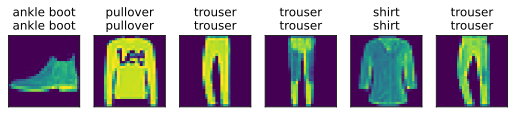

In [90]:
def predict_ch3(net, test_iter, n=6, device=None):
    """预测标签（从零实现版本）"""
    # 尝试从模型参数中自动推断设备，如果用户没有提供的话
    if device is None:
        device = next(iter(net.parameters())).device
    for X, y in test_iter:
        # 我们只需要一个批次的数据来进行可视化
        break
    trues = d2l.get_fashion_mnist_labels(y)
    # 关键步骤：将输入数据 X 移动到模型所在的设备 (GPU)
    X_on_gpu = X.to(device)
    # 在GPU上进行预测，得到的结果也在GPU上
    preds_on_gpu = net(X_on_gpu).argmax(axis=1)
    preds = d2l.get_fashion_mnist_labels(preds_on_gpu.cpu())
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape(n, 28, 28), 1, n, titles=titles[0:n])
predict_ch3(net,test_iter,device=device)

# 习题

### 1. Softmax 的数值稳定性问题 (上溢)

你直接根据数学定义实现的`softmax`函数如下：

```python
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition
```

**问题所在：数值上溢 (Numerical Overflow)**

当输入的`X`（通常是神经网络的输出，也称为 logits）中包含非常大的值时，`torch.exp(X)` 的计算结果可能会超出计算机浮点数所能表示的最大范围，导致结果变为无穷大 (`inf`)。

正如提示中提到的，我们来试试计算 `exp(50)`：
$e^{50} \approx 5.18 \times 10^{21}$
这个数值本身已经非常巨大。在32位浮点数（PyTorch中`torch.float32`的默认类型）中，能表示的最大值大约是 $3.4 \times 10^{38}$。虽然`exp(50)`没有直接溢出，但如果输入值再大一些，比如`exp(100)`，其结果约为 $2.68 \times 10^{43}$，就会立刻导致上溢，返回值变为 `inf`。

当这种情况发生时，`softmax`的计算就会变成：
$$ \text{softmax}(\mathbf{o})_j = \frac{e^{o_j}}{\sum_k e^{o_k}} \rightarrow \frac{\infty}{\infty} $$
这个结果在计算中会得到 `NaN` (Not a Number)，导致整个训练过程中的梯度计算等后续步骤全部失效。

***

### 2. Cross-Entropy 的数值稳定性问题 (下溢)

你实现的交叉熵损失函数如下：

```python
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])
```

**问题所在：对数函数的定义域**

`torch.log()` 函数的输入必须是正数 ($x > 0$)。`y_hat` 是 `softmax` 函数的输出，理论上是 (0, 1] 范围内的概率值。

问题在于，当 `softmax` 的某个输出概率值 `y_hat[i]` 极其接近0时（例如，由于数值精度限制，它可能被计算为0），`torch.log(y_hat[i])` 的结果将是负无穷 (`-inf`)。这被称为**数值下溢 (Numerical Underflow)**（指概率值的下溢）。这同样会给损失计算和梯度传播带来问题，导致梯度爆炸或变为 `NaN`。

这种情况通常发生在模型对某个样本的预测“错得离谱”时。例如，模型以接近100%的置信度预测样本属于类别A，但真实标签却是类别B。那么，对于类别B的预测概率 `y_hat[B]` 就会非常接近0，从而导致 `log(y_hat[B])` 计算出问题。

***

### 3. 针对问题1和2的解决方案

一个优雅且在所有深度学习框架中广泛应用的解决方案是将 `softmax` 运算和 `cross-entropy` 损失计算合并到一个函数中。这样做可以利用一个数学技巧来同时解决上溢和下溢问题。

**第一步：稳定 Softmax (解决上溢)**

为了防止 `exp` 计算时上溢，我们可以利用以下恒等式：
$$ \text{softmax}(\mathbf{o})_j = \frac{e^{o_j}}{\sum_k e^{o_k}} = \frac{e^{o_j} \cdot C}{\sum_k e^{o_k} \cdot C} = \frac{e^{o_j + \log C}}{\sum_k e^{o_k + \log C}} $$
我们可以选择一个巧妙的常数 $C$，让 $e^{o_j + \log C}$ 的值保持在合理的范围内。通常，我们选择 $\log C = -\max_k(o_k)$。这样，变换后的 logits $\mathbf{o'}$ 为：
$$ o'_j = o_j - \max_k(o_k) $$
此时，$\mathbf{o'}$ 中的最大值变为了0，所有值都小于等于0。这样再进行 `exp` 计算时，最大的结果是 $e^0=1$，就完全避免了上溢问题。

**第二步：合并 Softmax 和 Cross-Entropy (Log-Sum-Exp 技巧)**

交叉熵损失的完整计算公式（对于单个样本）是：
$$ L = -\log(\text{softmax}(\mathbf{o})_y) = -\log\left(\frac{e^{o_y}}{\sum_k e^{o_k}}\right) $$
其中 $y$ 是真实类别的索引。利用对数性质，我们可以将其展开：
$$ L = - \left( \log(e^{o_y}) - \log\left(\sum_k e^{o_k}\right) \right) = - \left( o_y - \log\left(\sum_k e^{o_k}\right) \right) = \log\left(\sum_k e^{o_k}\right) - o_y $$
这个 $\log(\sum_k e^{o_k})$ 就是著名的 **Log-Sum-Exp** 函数。直接计算它仍然可能因为 $\sum_k e^{o_k}$ 上溢而出错。但我们可以把第一步的技巧应用在这里：
$$ \log\left(\sum_k e^{o_k}\right) = \log\left(\sum_k e^{o_k - \max_i(o_i) + \max_i(o_i)}\right) = \log\left(e^{\max_i(o_i)} \sum_k e^{o_k - \max_i(o_i)}\right) $$
$$ = \max_i(o_i) + \log\left(\sum_k e^{o_k - \max_i(o_i)}\right) $$
这个最终形式是数值稳定的。因为 $o_k - \max_i(o_i) \le 0$，所以 $e^{o_k - \max_i(o_i)}$ 不会溢出。

**实践中的解决方案：**

在 PyTorch 中，我们不需要自己实现这个复杂的稳定版本。我们只需要使用 `torch.nn.CrossEntropyLoss` 即可。 这个损失函数会接收**未经 softmax 处理的原始 logits** 作为输入，并在内部完成所有数值稳定化的计算。

```python
# 正确的做法
loss_fn = torch.nn.CrossEntropyLoss()
# ... 在训练循环中 ...
# net的最后一层不应包含softmax
logits = net(X) 
# loss_fn 会自动应用 log-softmax
loss = loss_fn(logits, y) 
```

***

### 4. Argmax 是否总是最优解？

**答案是否定的。**

返回概率最大的分类标签（即 `argmax`）是一种决策策略，它隐含地假设**每种错误分类的代价都是相等的**。但在许多现实世界的应用中，这个假设并不成立。

**医疗诊断场景的例子：**

假设一个模型用于诊断病人是否患有癌症。有两种可能的错误：
1.  **假阴性 (False Negative)**: 模型预测病人**健康**，但实际上病人**患有癌症**。这个错误的代价是极高的，可能会导致病人错过最佳治疗时机，甚至危及生命。
2.  **假阳性 (False Positive)**: 模型预测病人**患有癌症**，但实际上病人是**健康的**。这个错误的代价相对较低，可能只是让病人接受了不必要的进一步检查（如活检），造成一定的经济负担和心理压力。

在这种**代价不对称**的情况下，我们不能简单地使用 `argmax`。 即使模型预测患癌的概率只有 40%（`P(cancer)=0.4`），而健康概率为 60%（`P(healthy)=0.6`），`argmax` 会选择“健康”。但考虑到假阴性的巨大风险，一个负责任的医生或系统可能会选择将该病人标记为“高风险”，并建议进行进一步检查。

在这种场景下，决策的依据应该结合模型的概率输出和不同错误的代价，而不是单纯地选择概率最高的那个。我们可能会调整决策阈值，或者更关注**召回率 (Recall)** 这类更能反映模型识别出所有正例能力的指标。

***

### 5. 大词汇量对 Softmax 回归的挑战

假设我们用 Softmax 回归来构建一个语言模型，预测下一个单词。这里的“可选取的单词数目”就是词汇表的大小（`vocab_size`），它对应于 Softmax 层的输出类别数。当 `vocab_size` 非常大时（例如，几十万甚至上百万），会带来以下主要问题：

1.  **计算成本高昂**：Softmax 回归的最后一步是一个线性层，其权重矩阵 `W` 的维度是 `(hidden_size, vocab_size)`。
    *   **前向传播**：计算 `logits = hidden_state @ W` 的矩阵乘法非常耗时。如果 `hidden_size` 是 512，`vocab_size` 是 50000，这个乘法就需要 `512 * 50000` 次乘加运算。
    *   **反向传播**：计算梯度同样需要大量的计算。

2.  **内存占用巨大**：存储这个巨大的权重矩阵 `W` 需要大量的内存（尤其是 GPU 显存）。以上述例子计算，仅存储这个矩阵就需要 `512 * 50000 * 4` 字节（假设是32位浮点数） $\approx$ 102 MB 的空间。对于更大的模型和词汇表，这会成为一个严重的瓶颈。

3.  **训练效率低下（数据稀疏性）**：对于一个庞大的词汇表，很多词（尤其是罕见词）在训练数据中出现的次数非常少。这意味着模型很难学习到这些罕见词的良好表示，导致对这些词的预测效果很差。在每次更新中，只有对应正确单词的那个输出权重才会被有效更新，大部分计算都是“浪费”的。

为了解决这些问题，研究人员开发了多种替代方案，如**分层 Softmax (Hierarchical Softmax)** 和**负采样 (Negative Sampling)** 等技术，它们通过近似计算来降低计算复杂性。